#HomeWork 08 : Campaign Response Model

Pisut Sukpool 6210422044

## **Importing libraries and datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/BADS_NIDA/CRM/hw8_campaign_response/'

In [43]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
random_state=99

In [4]:
df_response = pd.read_csv(path+'Retail_Data_Response.csv')
df_transactions = pd.read_csv(path+'Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [5]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [6]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


## **Data Preparation & Feature Engineering**

In [7]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


In [8]:
df_transactions['tran_amount'].describe()

count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

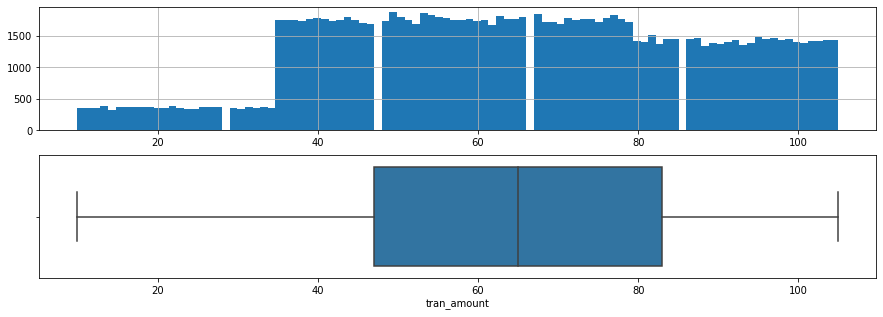

In [12]:
fig, axes = plt.subplots(2,1, figsize=(15,5))
df_transactions['tran_amount'].hist(bins=100, ax=axes[0])
sns.boxplot(data=df_transactions, x='tran_amount', ax=axes[1]);

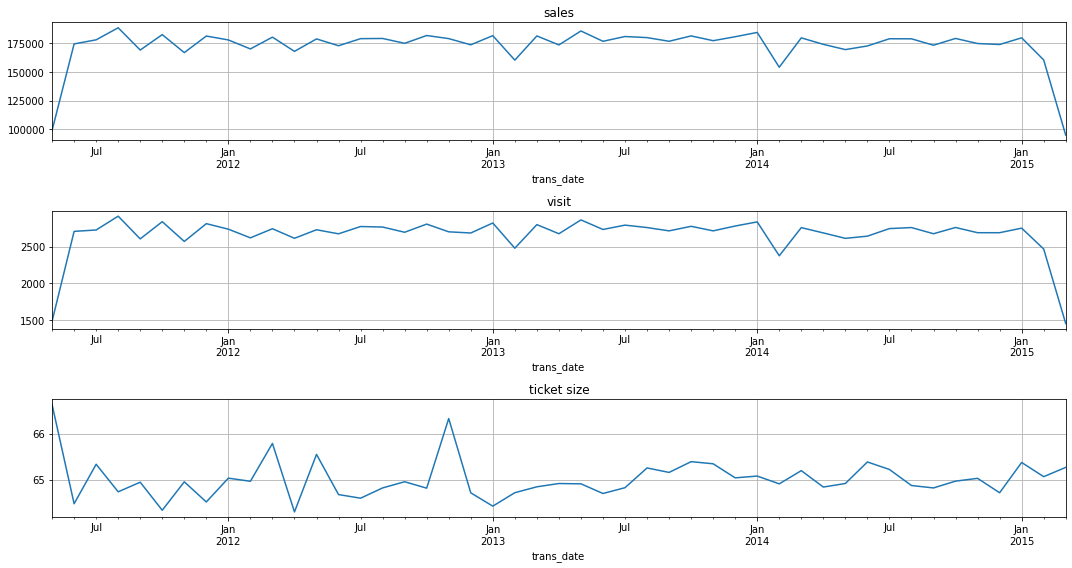

In [13]:
fig, axes = plt.subplots(3,1, figsize=(15,8), tight_layout=True)
axes = axes.ravel()

df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().plot(title='sales', ax=axes[0])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().plot(title='visit', ax=axes[1])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].apply(lambda x: x.sum()/x.count()).plot(title='ticket size')
for ax in axes:
    ax.grid(True)

plt.show()

In [14]:
campaign_date = dt.datetime(2015,3,17)

df_transactions['age'] = (campaign_date - df_transactions['trans_date']).dt.days
df_transactions['is_weekend'] = df_transactions['trans_date'].dt.weekday.isin([5,6])

df_transactions = df_transactions.sort_values(['customer_id','trans_date'])
df_transactions.head()

,customer_id,trans_date,tran_amount,age,is_weekend
77247,CS1112,2011-06-15,56,1371,False
89149,CS1112,2011-08-19,96,1306,False
68206,CS1112,2011-10-02,60,1262,True
36486,CS1112,2012-04-08,56,1073,True
93074,CS1112,2012-06-24,52,996,True


In [62]:
#Customer Movement
df_movement =  df_transactions[['customer_id','trans_date']]
df_movement['date_lag'] = df_movement.groupby(['customer_id'])['trans_date'].shift(1)
df_movement['date_lead'] = df_movement.groupby(['customer_id'])['trans_date'].shift(-1)
df_movement['date_diff'] = (df_movement['trans_date'] - df_movement['date_lag']).dt.days

conditions_active_1_month = [
    (df_movement['date_diff'] <= 30),
    (df_movement['date_diff'] > 30)
    ]
values_active_1_month = ['Repeat', 'Reactivated']
df_movement['Movement_active_1m'] = np.select(conditions_active_1_month, values_active_1_month)

conditions_active_2_month = [
    (df_movement['date_diff'] <= 60),
    (df_movement['date_diff'] > 60)
    ]
values_active_2_month = ['Repeat', 'Reactivated']
df_movement['Movement_active_2m'] = np.select(conditions_active_2_month, values_active_2_month)

conditions_active_3_month = [
    (df_movement['date_diff'] <= 90),
    (df_movement['date_diff'] > 90)
    ]   
values_active_3_month = ['Repeat', 'Reactivated']
df_movement['Movement_active_3m'] = np.select(conditions_active_3_month, values_active_3_month)
df_movement.loc[df_movement['Movement_active_1m'] == '0', 'Movement_active_1m'] = 'New'
df_movement.loc[df_movement['Movement_active_2m'] == '0', 'Movement_active_2m'] = 'New'
df_movement.loc[df_movement['Movement_active_3m'] == '0', 'Movement_active_3m'] = 'New'
#filter = df_movement['customer_id']=='CS1112' 
#df_movement.where(filter, inplace = True)

df_movement_1m =  df_movement[['customer_id','trans_date','Movement_active_1m']]
df_movement_2m =  df_movement[['customer_id','trans_date','Movement_active_2m']]
df_movement_3m =  df_movement[['customer_id','trans_date','Movement_active_3m']]

df_movement_1m=df_movement_1m.pivot_table(index='customer_id',columns='Movement_active_1m',values='trans_date',aggfunc='count',fill_value=0).add_suffix('_active_1m')
df_movement_2m=df_movement_2m.pivot_table(index='customer_id',columns='Movement_active_2m',values='trans_date',aggfunc='count',fill_value=0).add_suffix('_active_2m')
df_movement_3m=df_movement_3m.pivot_table(index='customer_id',columns='Movement_active_3m',values='trans_date',aggfunc='count',fill_value=0).add_suffix('_active_3m')


df_movement_1m.columns.name = None    
df_movement_1m = df_movement_1m.reset_index()  
df_movement_2m.columns.name = None    
df_movement_2m = df_movement_2m.reset_index()  
df_movement_3m.columns.name = None    
df_movement_3m = df_movement_3m.reset_index()  

df_movement_1m = df_movement_1m[['customer_id','Reactivated_active_1m','Repeat_active_1m']]
df_movement_2m = df_movement_2m[['customer_id','Reactivated_active_2m','Repeat_active_2m']]
df_movement_3m = df_movement_3m[['customer_id','Reactivated_active_3m','Repeat_active_3m']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [63]:
df = df_transactions.groupby('customer_id').agg(
        recency=('age', min),                       
        frequency=('customer_id', len),                  
        monetary=('tran_amount', sum), 
        length_of_stay=('age', lambda x: x.max() - x.min()),
     )

# weekend
weekend_df = df_transactions.groupby(['customer_id','is_weekend'])['tran_amount'].agg(['size','sum','mean']).unstack(fill_value=0)
weekend_df.columns = ['visit_weekday','visit_weekend','spend_weekday','spend_weekend','ticket_size_weekday','ticket_size_weekend']
df = df.join(weekend_df)


df = df.join(df_transactions.groupby('customer_id').agg(
    ticket_size=('tran_amount','mean'),
    std_ticket_size=('tran_amount','std'),
    med_ticket_size=('tran_amount','median'),
    mad_ticket_size=('tran_amount','mad'),
    
))

# time to event
event_df = df_transactions.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
event_df['num_repeat_sameday'] = event_df['num_trans'] - 1
event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days

df = df.join(event_df.groupby('customer_id').agg(avg_duration=('duration','mean'),std_duration=('duration','std'),
                                                num_repeat_periods=('trans_date', lambda x: x.count() - 1),
                                                num_repeat_sameday=('num_repeat_sameday','sum')))

# RFM with Time to event
periods = [6, 12, 18, 24]
for n in periods:
    window_df = df_transactions[df_transactions.trans_date > df_transactions.trans_date.max() - relativedelta(months=n)]

    df = df.join(window_df.groupby('customer_id')['tran_amount'].agg(
        [ (f'monetary_{n}m','sum'), (f'frequency_{n}m', 'size'), 
        (f'avg_spend_{n}m', 'mean'), (f'std_spend_{n}m', 'std'),
         (f'iqr_spend_{n}m', lambda x: x.quantile(0.75) - x.quantile(0.25))]
    ))

    event_df = window_df.groupby(['customer_id','trans_date']).size().reset_index(name='num_trans')
    event_df['prev_date'] = event_df.groupby('customer_id')['trans_date'].shift(1)
    event_df['duration'] = (event_df['trans_date'] - event_df['prev_date']).dt.days
    df = df.join(event_df.groupby('customer_id')['duration'].agg(
        [ (f'avg_dur_{n}m', 'mean'), (f'std_dur_{n}m', 'std'), 
         (f'iqr_dur_{n}m', lambda x: x.quantile(.75) - x.quantile(.25)),
         (f'num_repeat_{n}m', 'count')
         ]
    ))


df.fillna(0, inplace=True)
df = df_response.set_index('customer_id').join(df)
df.head()

,response,recency,frequency,monetary,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,0,62,15,1012,1309,10,5,696,316,69.600000,63.200000,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14,0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0
CS1113,0,36,20,1490,1354,17,3,1296,194,76.235294,64.666667,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18,1,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0
CS1114,1,33,19,1432,1309,13,6,955,477,73.461538,79.500000,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18,0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0
CS1115,1,12,22,1659,1303,16,6,1183,476,73.937500,79.333333,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21,0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0
CS1116,1,204,13,857,1155,12,1,797,60,66.416667,60.000000,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0


In [64]:
df = df_movement_1m.set_index('customer_id').join(df)
df = df_movement_2m.set_index('customer_id').join(df)
df = df_movement_3m.set_index('customer_id').join(df)
df.head()

,Reactivated_active_3m,Repeat_active_3m,Reactivated_active_2m,Repeat_active_2m,Reactivated_active_1m,Repeat_active_1m,response,recency,frequency,monetary,length_of_stay,visit_weekday,visit_weekend,spend_weekday,spend_weekend,ticket_size_weekday,ticket_size_weekend,ticket_size,std_ticket_size,med_ticket_size,mad_ticket_size,avg_duration,std_duration,num_repeat_periods,num_repeat_sameday,monetary_6m,frequency_6m,avg_spend_6m,std_spend_6m,iqr_spend_6m,avg_dur_6m,std_dur_6m,iqr_dur_6m,num_repeat_6m,monetary_12m,frequency_12m,avg_spend_12m,std_spend_12m,iqr_spend_12m,avg_dur_12m,std_dur_12m,iqr_dur_12m,num_repeat_12m,monetary_18m,frequency_18m,avg_spend_18m,std_spend_18m,iqr_spend_18m,avg_dur_18m,std_dur_18m,iqr_dur_18m,num_repeat_18m,monetary_24m,frequency_24m,avg_spend_24m,std_spend_24m,iqr_spend_24m,avg_dur_24m,std_dur_24m,iqr_dur_24m,num_repeat_24m
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CS1112,5,9,11,3,13,1,0.0,62.0,15.0,1012.0,1309.0,10.0,5.0,696.0,316.0,69.600000,63.200000,67.466667,19.766012,63.0,15.831111,93.500000,50.873523,14.0,0.0,98.0,2.0,49.000000,14.142136,10.0,41.0,0.000000,0.0,1.0,251.0,4.0,62.750000,20.982135,15.75,86.666667,50.560195,50.00,3.0,322.0,5.0,64.400000,18.541845,12.00,106.750000,57.598466,78.75,4.0,358.0,6.0,59.666667,20.235283,25.0,112.400000,51.456778,63.00,5.0
CS1113,5,14,8,11,14,5,0.0,36.0,20.0,1490.0,1354.0,17.0,3.0,1296.0,194.0,76.235294,64.666667,74.500000,21.254102,79.5,18.300000,75.222222,53.395919,18.0,1.0,220.0,3.0,73.333333,27.300794,27.0,26.0,0.000000,0.0,1.0,393.0,6.0,65.500000,28.939592,51.25,74.000000,65.181797,54.50,4.0,446.0,7.0,63.714286,26.837252,45.50,79.600000,57.821276,64.00,5.0,775.0,11.0,70.454545,23.888757,43.0,73.333333,58.030165,76.00,9.0
CS1114,7,11,8,10,10,8,1.0,33.0,19.0,1432.0,1309.0,13.0,6.0,955.0,477.0,73.461538,79.500000,75.368421,21.341692,79.0,17.955679,72.722222,73.693168,18.0,0.0,211.0,3.0,70.333333,29.955523,29.0,31.0,16.970563,12.0,2.0,315.0,5.0,63.000000,23.822258,33.00,41.250000,44.002841,43.25,4.0,652.0,9.0,72.444444,26.495807,49.00,53.375000,69.903888,42.50,8.0,804.0,11.0,73.090909,24.010225,42.5,62.600000,64.740851,82.00,10.0
CS1115,3,18,9,12,14,7,1.0,12.0,22.0,1659.0,1303.0,16.0,6.0,1183.0,476.0,73.937500,79.333333,75.409091,18.151896,72.5,15.264463,62.047619,55.413425,21.0,0.0,55.0,1.0,55.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,248.0,3.0,82.666667,24.006943,21.50,165.000000,134.350288,95.00,2.0,590.0,8.0,73.750000,16.951612,16.75,76.142857,85.762130,54.00,7.0,831.0,11.0,75.545455,15.577956,19.5,71.500000,71.019950,47.75,10.0
CS1116,4,8,6,6,8,4,1.0,204.0,13.0,857.0,1155.0,12.0,1.0,797.0,60.0,66.416667,60.000000,65.923077,22.940000,60.0,19.751479,96.250000,107.361010,12.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,286.0,4.0,71.500000,26.248809,36.50,52.333333,37.740341,34.50,3.0,333.0,5.0,66.600000,25.234896,43.00,49.750000,31.245000,38.25,4.0,333.0,5.0,66.600000,25.234896,43.0,49.750000,31.245000,38.25,4.0


In [66]:
df = df.dropna(axis=0, subset=['recency'])
df.to_excel('prep_data.xlsx')

## **Calculating response rate**

In [67]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


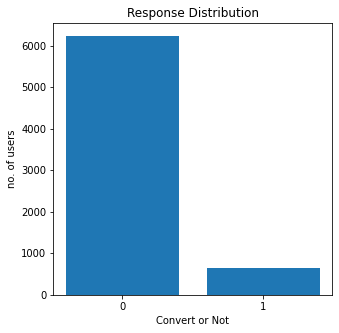

In [68]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

## **Creating train and test dataset**

In [69]:
## spliting dataframe into X and y

X = df.drop(columns=['response'])
y = df['response']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 60)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 60)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

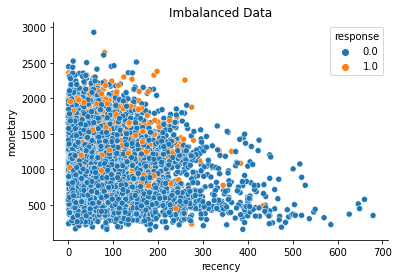

In [71]:
sns.scatterplot(data=df, x='recency', y='monetary', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

[0.36659961 0.09384789]


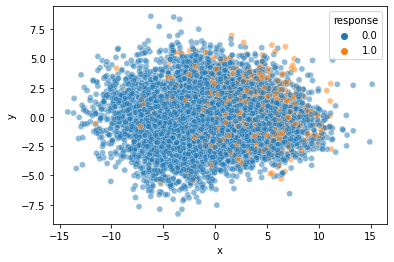

In [72]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = df.drop(['response'],axis=1)
X_std = scale(X)

pca = PCA(2)
embed = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)
sns.scatterplot(data=pd.DataFrame({'x':embed[:,0],'y':embed[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5);

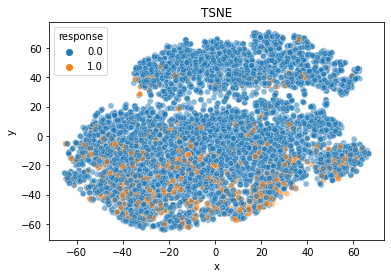

In [73]:
from sklearn.manifold import TSNE
embed_tsne = TSNE(2).fit_transform(X_std)
sns.scatterplot(data=pd.DataFrame({'x':embed_tsne[:,0],'y':embed_tsne[:,1],'response':df['response']}), x='x', y='y', hue='response', alpha=.5)
plt.title('TSNE');

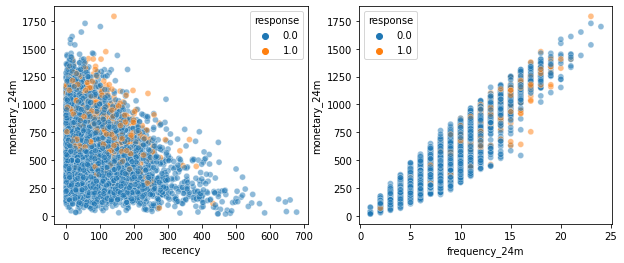

In [74]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(data=df, x='recency', y='monetary_24m', hue='response', alpha=.5, ax=axes[0])
sns.scatterplot(data=df, x='frequency_24m', y='monetary_24m', hue='response', alpha=.5, ax=axes[1])
plt.show()

## **Evaluation**

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline

undersampler = RandomUnderSampler(random_state=random_state)
oversampler = RandomOverSampler(random_state=random_state)
smote = SMOTE(random_state=random_state)
smote_tomek = SMOTETomek(random_state=random_state)
smote_enn = SMOTEENN(random_state=random_state)

resamplers = [
    ('n/a', None),
    ('undersampler', undersampler),
    ('oversampler', oversampler),
    ('smote', smote),
    ('smote-tomek', smote_tomek),
    ('smote-enn', smote_enn)
]

kf = StratifiedKFold(n_splits=5)

metric_cols = ['model','resampler','cv-train-mean','cv-train-std','cv-val-mean','cv-val-std','test']

def display_metrics(df):
    return df.style.bar(subset=['cv-train-mean'], color='lightskyblue')\
                    .bar(subset=['cv-val-mean'], color='lightsalmon')\
                    .bar(subset=['cv-train-std','cv-val-std'], color='lightgray')\
                    .bar(subset=['test'], color='lightgreen')\
                    .format({'cv-train-mean':'{:.2%}','cv-val-mean':'{:.2%}','cv-train-std':'{:.2%}','cv-val-std':'{:.2%}','train':'{:.2%}', 'val':'{:.2%}', 'test':'{:.2%}'})

def get_resample(x, y, resampler=None):
    """
    Exepcted x, y as DataFrame and Series
    """
    if resampler:
        x_rs, y_rs = resampler.fit_resample(x, y)
        x_rs = pd.DataFrame(x_rs, columns=x.columns) 
        y_rs = pd.Series(y_rs, name=y.name)
    else:
        x_rs, y_rs = x, y
    return x_rs, y_rs

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

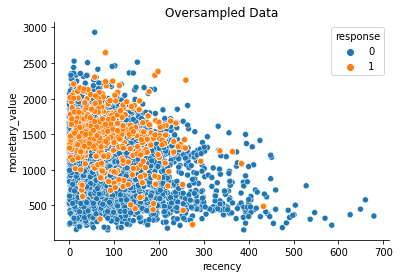

In [ ]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

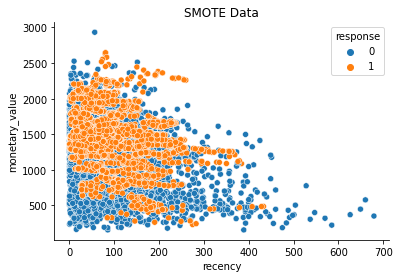

In [ ]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [ ]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       429
           1       0.65      0.72      0.69       429

    accuracy                           0.67       858
   macro avg       0.67      0.67      0.67       858
weighted avg       0.67      0.67      0.67       858

test set
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      1848
           1       0.18      0.76      0.30       218

    accuracy                           0.62      2066
   macro avg       0.57      0.68      0.52      2066
weighted avg       0.87      0.62      0.69      2066



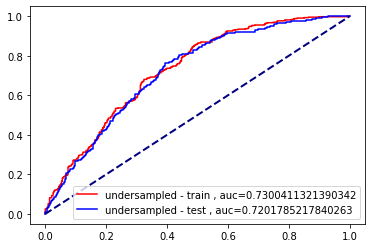

In [ ]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [ ]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 0.00368411 -0.03621944  0.00246363]] [-2.80649227]


In [ ]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.67      0.62      0.65      4389
           1       0.65      0.69      0.67      4389

    accuracy                           0.66      8778
   macro avg       0.66      0.66      0.66      8778
weighted avg       0.66      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1848
           1       0.19      0.72      0.30       218

    accuracy                           0.64      2066
   macro avg       0.57      0.68      0.53      2066
weighted avg       0.87      0.64      0.71      2066



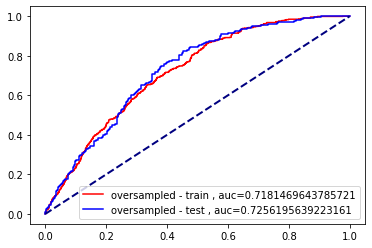

In [ ]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [ ]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[0.00415889 0.02516016 0.00181298]] [-2.80649227]


In [ ]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      4389
           1       0.65      0.71      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1848
           1       0.18      0.71      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.52      2066
weighted avg       0.87      0.64      0.71      2066



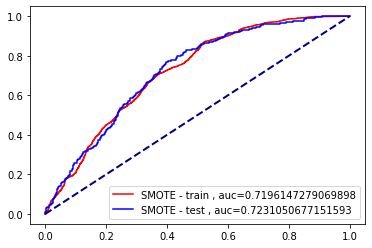

In [ ]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [ ]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[0.00371859 0.00684075 0.00207781]] [-2.80649227]


## **XGBoost**

In [ ]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.705229
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.713788
[2]	validation_0-auc:0.716027
[3]	validation_0-auc:0.716674
[4]	validation_0-auc:0.715722
[5]	validation_0-auc:0.716981
[6]	validation_0-auc:0.715989
[7]	validation_0-auc:0.717465
[8]	validation_0-auc:0.716698
[9]	validation_0-auc:0.718954
[10]	validation_0-auc:0.718443
[11]	validation_0-auc:0.720803
[12]	validation_0-auc:0.721902
[13]	validation_0-auc:0.721018
[14]	validation_0-auc:0.722452
[15]	validation_0-auc:0.723688
[16]	validation_0-auc:0.723585
[17]	validation_0-auc:0.726791
[18]	validation_0-auc:0.727038
[19]	validation_0-auc:0.727042
[20]	validation_0-auc:0.727542
[21]	validation_0-auc:0.727999
[22]	validation_0-auc:0.728137
[23]	validation_0-auc:0.729541
[24]	validation_0-auc:0.729021
[25]	validation_0-auc:0.728669
[26]	validation_0-auc:0.728642
[27]	validation_0-auc:0.73034
[28]	validation_0-auc:0.730049
[29]	validation_0-au

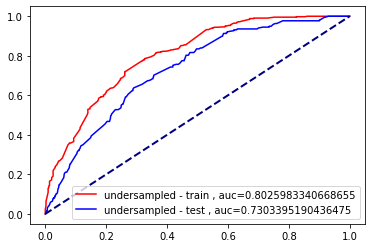

In [ ]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

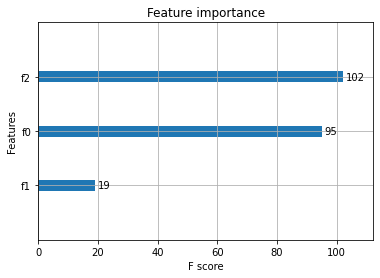

In [ ]:
xgb.plot_importance(xgb_model_under)

In [ ]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.71776
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.730129
[2]	validation_0-auc:0.731335
[3]	validation_0-auc:0.732199
[4]	validation_0-auc:0.732009
[5]	validation_0-auc:0.733986
[6]	validation_0-auc:0.734008
[7]	validation_0-auc:0.734353
[8]	validation_0-auc:0.734721
[9]	validation_0-auc:0.734507
[10]	validation_0-auc:0.737226
[11]	validation_0-auc:0.737584
[12]	validation_0-auc:0.737529
[13]	validation_0-auc:0.738018
[14]	validation_0-auc:0.738306
[15]	validation_0-auc:0.738075
[16]	validation_0-auc:0.73867
[17]	validation_0-auc:0.738399
[18]	validation_0-auc:0.738837
[19]	validation_0-auc:0.738752
[20]	validation_0-auc:0.738777
[21]	validation_0-auc:0.73744
[22]	validation_0-auc:0.738809
[23]	validation_0-auc:0.738641
Stopping. Best iteration:
[18]	validation_0-auc:0.738837

training set
              precision    recall  f1-score   support

           0       0.76      0.54      0.63      438

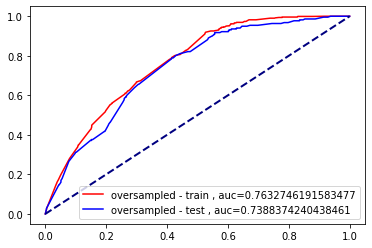

In [ ]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

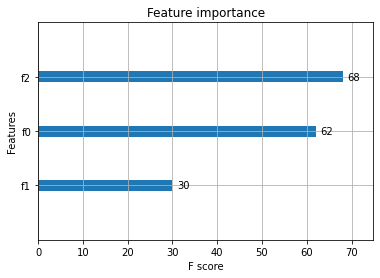

In [ ]:
xgb.plot_importance(xgb_model_over)

In [ ]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.719724
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.723431
[2]	validation_0-auc:0.735221
[3]	validation_0-auc:0.734822
[4]	validation_0-auc:0.733489
[5]	validation_0-auc:0.734515
[6]	validation_0-auc:0.73512
[7]	validation_0-auc:0.739788
[8]	validation_0-auc:0.737715
[9]	validation_0-auc:0.743504
[10]	validation_0-auc:0.743524
[11]	validation_0-auc:0.739335
[12]	validation_0-auc:0.740311
[13]	validation_0-auc:0.738329
[14]	validation_0-auc:0.7399
[15]	validation_0-auc:0.739269
Stopping. Best iteration:
[10]	validation_0-auc:0.743524

training set
              precision    recall  f1-score   support

           0       0.81      0.59      0.69      4389
           1       0.68      0.86      0.76      4389

    accuracy                           0.73      8778
   macro avg       0.75      0.73      0.72      8778
weighted avg       0.75      0.73      0.72      8778

test set
              precision  

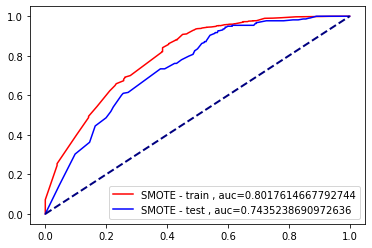

In [ ]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

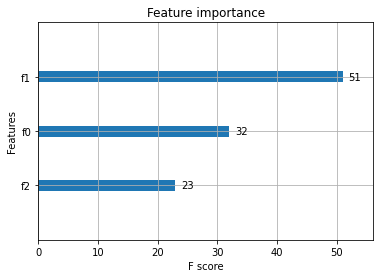

In [ ]:
xgb.plot_importance(xgb_model_SMOTE)

In [ ]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.611373
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.733395
[2]	validation_0-auc:0.728699
[3]	validation_0-auc:0.738274
[4]	validation_0-auc:0.738525
[5]	validation_0-auc:0.732941
[6]	validation_0-auc:0.740621
[7]	validation_0-auc:0.741142
[8]	validation_0-auc:0.740015
[9]	validation_0-auc:0.739549
[10]	validation_0-auc:0.741946
[11]	validation_0-auc:0.737816
[12]	validation_0-auc:0.738247
[13]	validation_0-auc:0.737253
[14]	validation_0-auc:0.736756
[15]	validation_0-auc:0.736153
Stopping. Best iteration:
[10]	validation_0-auc:0.741946

training set
              precision    recall  f1-score   support

           0       0.81      0.63      0.71      4389
           1       0.70      0.86      0.77      4389

    accuracy                           0.74      8778
   macro avg       0.76      0.74      0.74      8778
weighted avg       0.76      0.74      0.74      8778

test set
   